In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from datetime import datetime, timedelta
from scipy import stats
import statsmodels.api as sm
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings('ignore')

## Step 1

#### Extend the PCA monitoring framework in lesson 4.3 with the goal of obtaining a systemic risk indicator combining signals of correlation breakdown and of widening credit spread

The computational framework adopted in lesson $\S \, 4.3$ made use of nine ETFs of the SPDR series, issued by State Street to target specific industry and service sectors in the economy, with each ETF composed exclusively of stocks that are within the S&P500 index.
The computations start from January 2007 and extend until the present date. 
That is why only the nine ETFs already existing in 2007, out of the full suite of eleven SPDR ETFs, were used in the analysis.

Beyond the SPDR ETFs, extra tickers were tracked to follow the volatility of the markets (^VIX), the 10-year Treasury bonds yields (^TNX), and an ETF from iShares reproducing the yield of investment grade corporate bonds (LQD).

All of the data series above are taken with a daily frequency at markets closing time.

Further, we gather daily yield series from the FRED database, for Baa investment grade $\geq 20$-year corporate bonds as graded by Moody's (BAA) and again the 10-year Treasury bond yields (DGS10).

To summarise:

| Ticker | Description |
|:------:|:------------|
| **SPDR ETFs**
| `XLB`  | S&P500 Materials stocks |
| `XLE`  | S&P500 Energy stocks |
| `XLF`  | S&P500 Financial stocks |
| `XLI`  | S&P500 Industrial stocks |
| `XLK`  | S&P500 Technology stocks |
| `XLP`  | S&P500 Consumer Staples stocks |
| `XLU`  | S&P500 Utilities stocks |
| `XLV`  | S&P500 Healthcare stocks |
| `XLY`  | S&P500 Consumer Discretionary stocks |
| **other market data**
| `^VIX` | Market volatility index |
| `^TNX` | 10-year Treasury yields index|
| `LQD`  | Liquid, investment-grade corporate bond yields |
| **FRED data**
| `BAA`  | Moody's Baa-rated corporate bond yields |
| `DGS10`| 10-year Treasury yields |


Below, the shape of the `pandas` DataFrame for the 9 SPDR ETFs downloaded, sporting for dimensions the number of daily observations for the period 2007-2025 (after data cleaning) $\times$ the 9 ETFs.

In [19]:
# 11 Sector ETFs + VIX & 10‑yr yield for validation
sector_tickers = [
    "XLK", "XLF", "XLV", "XLE", "XLI", "XLY",
    "XLP", "XLB", "XLU"#, "^GSPC"
]
extra_tickers = ["^VIX", "^TNX", "LQD"] #"SP500BDT"]    # VIX and 10‑yr Treasury yield

start = "2007-01-04"
end = datetime.today() - timedelta(days=1)
end = end.strftime("%Y-%m-%d")
raw = pd.DataFrame(
    yf.download(sector_tickers + extra_tickers, start=start, end=end, progress=False, auto_adjust=True)
)["Close"]

# Drop rows with all‑NaNs (market holidays)
prices = raw.dropna(how="all")

# 1. Daily log‑returns
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()

# 2. Winsorise 4‑sigma tails (simple clip)
sigma4 = 4 * rets.std()
rets = rets.clip(lower=-sigma4, upper=sigma4, axis=1)

# 3. Selecting the sector returns
sector_rets = rets[sector_tickers]         # 9 × T matrix

sector_rets.shape

(4684, 9)

We see that the number of observations for the remaining data series extracted from markets agrees with the previous database at 4684 datapoints:

In [20]:
rets[["^VIX", "^TNX", "LQD"]].shape

(4684, 3)

FRED series `BAA`, although nominally taken with daily frequency as declared on the FRED website, in reality exhibits monthly frequency when extracted from the database.

In [21]:
fred = Fred(api_key="94fd20817a25e8215aa058f93235ba89")

fred.get_series_info("BAA")

id                                                                         BAA
realtime_start                                                      2025-08-21
realtime_end                                                        2025-08-21
title                                Moody's Seasoned Baa Corporate Bond Yield
observation_start                                                   1919-01-01
observation_end                                                     2025-07-01
frequency                                                              Monthly
frequency_short                                                              M
units                                                                  Percent
units_short                                                                  %
seasonal_adjustment                                    Not Seasonally Adjusted
seasonal_adjustment_short                                                  NSA
last_updated                                        

A workaround is found in downloading FRED's `DBAA` series instead, with the initial letter D evidently standing for *daily*.

Given that the Treasury yields data `DGS10` have more observations than all other series downloaded, in fact spanning over days when markets were closed, we will fill the missing datapoints in `DBAA` with the previous most recent observation available.

There also exist a FRED series `BAA10Y` = `DBAA` - `DGS10` which tracks the credit spread of investment-grade corporate bonds out of the box.
The graph below shows `BAA10Y` is obtained exactly as `DBAA` - `DGS10`.

In [22]:
fred_ids = {
    "DBAA"    : "DBAA",     # Moody Baa yield (% p.a.)
    "UST10"  : "DGS10",   # 10y Treasury yield (% p.a.)
    "BAA10Y" : "BAA10Y"
    # "UNRATE" : "UNRATE",  # Unemployment rate (%)
    # "INDPRO" : "INDPRO",  # Industrial production index (2017=100)
    # "FEDFUNDS": "FEDFUNDS",
    # "REC"    : "USREC"    # Recession indicator (0/1)
}

fred_data = pd.concat({k: fred.get_series(v, observation_start=start, observation_end=end)
                  for k, v in fred_ids.items()}, axis=1).ffill().dropna()

fred_data.shape

(4862, 3)

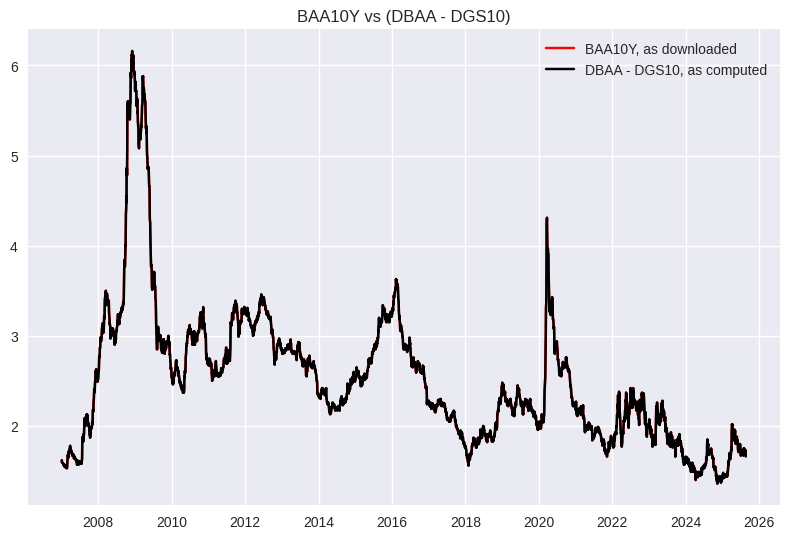

In [23]:
# check BAA10Y is exactly DBAA - DGS10
fig, ax = plt.subplots()
ax.plot(fred_data.index, fred_data["BAA10Y"], 'r', label="BAA10Y, as downloaded")
ax.plot(fred_data.index, fred_data["DBAA"] - fred_data["UST10"], 'k', label="DBAA - DGS10, as computed")
plt.title("BAA10Y vs (DBAA - DGS10)")
plt.legend()
plt.tight_layout()
plt.show()

For the sake of comparing the credit spread obtained from FRED data (`BAA10Y`) with the one obtained from market data (`LQD` - `^TNX`), we first adapt the latter to have the same number of observations of the former.

In [56]:
# Credit spread in decimal form
spread_fred = fred_data["BAA10Y"] / 100   # from % to decimal per annum
spread_fred.name = "Credit Spread from FRED"
spread_market = pd.Series(data=abs(rets["LQD"] - rets["^TNX"]), index=fred_data.index, name="Credit Spread from markets").ffill()

print("shape of spread data from markets: ", spread_market.shape)

shape of spread data from markets:  (4862,)


In [54]:
print("shape of spread data from FRED: ", spread_fred.shape)

shape of spread data from FRED:  (4862,)


The credit spreads so obtained by two different sources are plotted in the figure below.

It is evident that the market measure (blue) is much more noisy than that obtained from FRED data (red).
We attribute this to the nature of `LQD` as a liquid (highly traded) instrument.
Its price is determined by supply and demand dynamics, rather than by the yields of the corporate bonds undergirding it.
In turn, this price will reflect the bonds' yields, but only indirectly through market participants' behaviour.

In support of the previous observation, we observe that the absolute value of the noisy market data seems to follow the same patterns as the more regular FRED data.
The two measures of credit spread seem to be correlated.

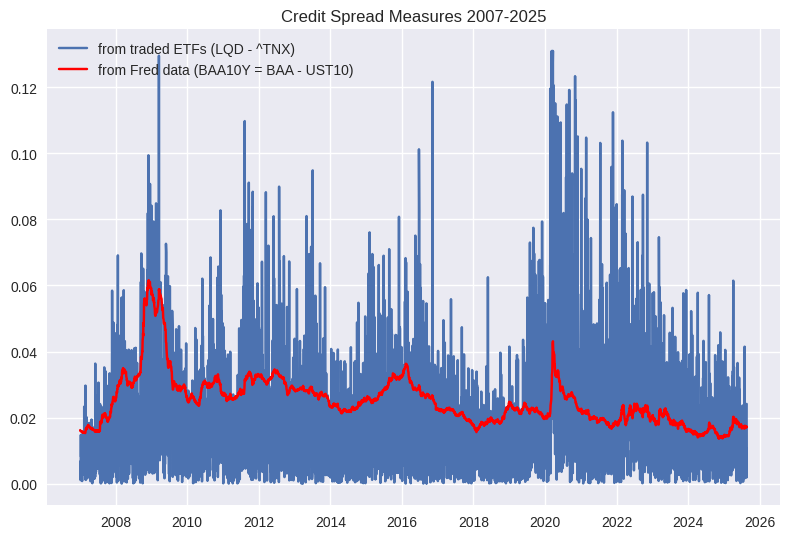

In [ ]:
fig = plt.figure()
plt.plot(spread_market.index, spread_market, label="from traded ETFs (LQD - ^TNX)")
plt.plot(spread_fred.index, spread_fred, color='r', label="from Fred data (BAA10Y = BAA - UST10)")
plt.legend()
plt.title("Credit Spread Measures 2007-2025")
plt.tight_layout()
plt.show()

Now, in order to observe the correlations amongst the SPDR ETFs during the selected 2007-25 time window, we compute rolling correlation matrices for time windows of 60 trading days, advancing one day at the time.

The spectral decomposition (or PCA) of these rolling correlation matrices will yield the eigenvalues of the matrices.
The largest eigenvalue is found to represent the *market factor* that affects all securities, determining parallel shifts in stock prices.

Its *explained variance ratio* (EVR), i.e. the fraction of total portfolio variance it explains, grows in times of increased market uncertainty.
This consists in an undesirable increase in global correlation that could be exploited as a signal for a possibly incipient financial crisis.

In [ ]:
def rolling_pca(returns, correlation_type, window=60):
    """
    correlation_type : str, choose among 'pearson', 'spearman' and 'kendall'
    returns : DataFrame (T x N) of zero-mean daily returns
    returns, evr        : DataFrame indexed by window end-date
    loadings_list       : list of Γ matrices (N x N) per window
    """

    evr_list, score_list, loadings_list = [], [], []
    idx = returns.index

    for t in range(window - 1, len(idx)):
        X = returns.iloc[t - window + 1 : t + 1]
        # C = np.corrcoef(X.T)                         # 11×11
        C = X.corr(method=correlation_type)
        vals, vecs = np.linalg.eigh(C)               # ascending

        # Sort descending and fix PC1 sign so XLK loading positive
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        if vecs[sector_tickers.index("XLK"), 0] < 0:
            vecs[:, 0] *= -1
        # Same procedure for PC2 & PC3 if desired (not necessary)

        evr_list.append(vals / vals.sum())
        loadings_list.append(vecs)
        score_list.append(vecs.T @ returns.iloc[t].values)

    dates = idx[window - 1 :]
    evr = pd.DataFrame(evr_list, index=dates,
                       columns=[f"EVR{k}" for k in range(1, len(returns.columns)+1)])
    scores = pd.DataFrame(score_list, index=dates,
                          columns=[f"PC{k}_score" for k in range(1, len(returns.columns)+1)])
    return evr, scores, loadings_list


evr, pcscores, _ = rolling_pca(sector_rets, 'pearson', window=60)

EVR1 = evr["EVR1"]
PC2_z = (pcscores["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score = pcscores["PC3_score"]

vix = prices["^VIX"].loc[EVR1.index]
tnx = prices["^TNX"].loc[EVR1.index] / 100        # ^TNX quote is yield×100

<AxesSubplot: xlabel='Ticker', ylabel='Ticker'>

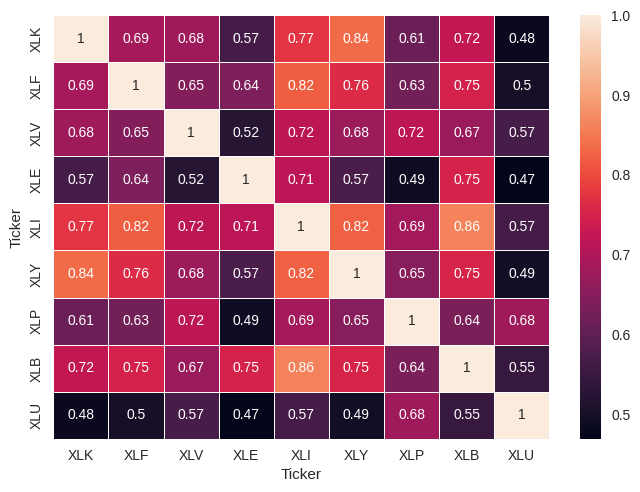

In [11]:
C_pearson = pd.DataFrame(np.corrcoef(sector_rets.T), index=sector_rets.columns, columns=sector_rets.columns)
sns.heatmap(C_pearson, annot=True, linewidth=.5)

<AxesSubplot: xlabel='Ticker', ylabel='Ticker'>

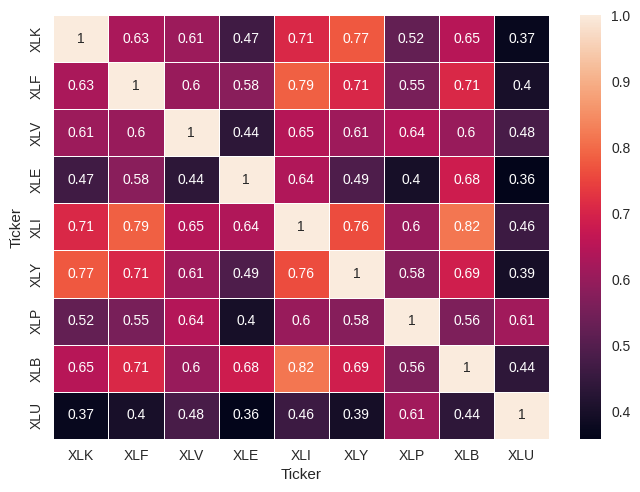

In [12]:
# spearman correlation
C_spearman = sector_rets.corr(method='spearman')
sns.heatmap(C_spearman, annot=True, linewidth=.5)

<AxesSubplot: xlabel='Ticker', ylabel='Ticker'>

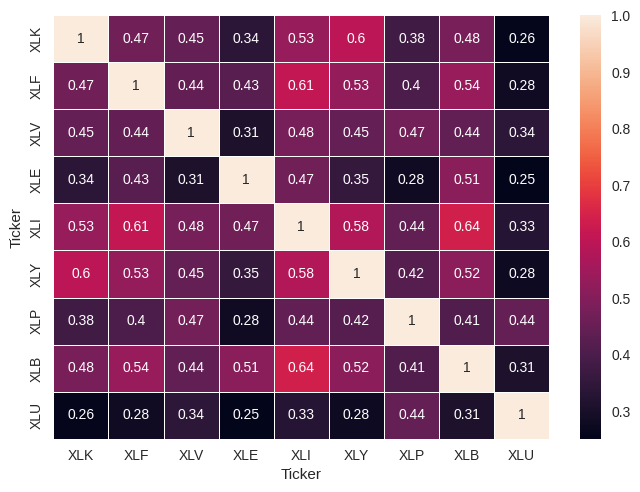

In [13]:
# kendall correlation
C_kendall = sector_rets.corr(method='kendall')
sns.heatmap(C_kendall, annot=True, linewidth=.5)

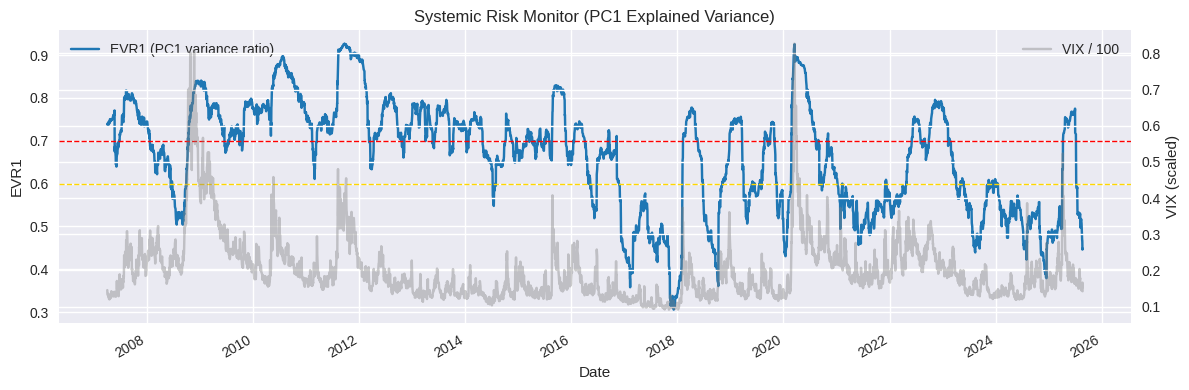

In [14]:
fig, ax1 = plt.subplots(figsize=(12,4))
EVR1.plot(ax=ax1, color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1.axhline(0.60, ls="--", color="gold", lw=1)
ax1.axhline(0.70, ls="--", color="red", lw=1)
ax1.set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance)")
ax2 = ax1.twinx()
(vix/100).plot(ax=ax2, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2.set_ylabel("VIX (scaled)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout()


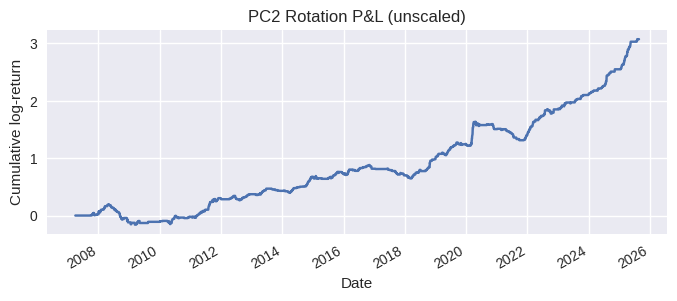

In [15]:
# 1. Trading signal: +1 = long‑cyclical, –1 = long‑defensive
signal = pd.Series(
    np.where(PC2_z < -1.5, -1,
    np.where(PC2_z >  1.5, 1, 0)),
    index=PC2_z.index
).fillna(0)                      # early NaNs → flat position

# 2. Cyclical and defensive legs
cyclical   = sector_rets[["XLK","XLY","XLE"]].mean(axis=1)
defensive  = sector_rets[["XLP","XLU","XLV"]].mean(axis=1)
spread     = cyclical - defensive

# 3. Align indices (inner join) and compute P&L
aligned = pd.concat([signal, spread], axis=1, join="inner").dropna()
rotation_pnl = (aligned.iloc[:,0] * aligned.iloc[:,1]).cumsum()

# 4. Plot
rotation_pnl.plot(figsize=(8,3),
                  title="PC2 Rotation P&L (unscaled)",
                  ylabel="Cumulative log-return")
plt.show()

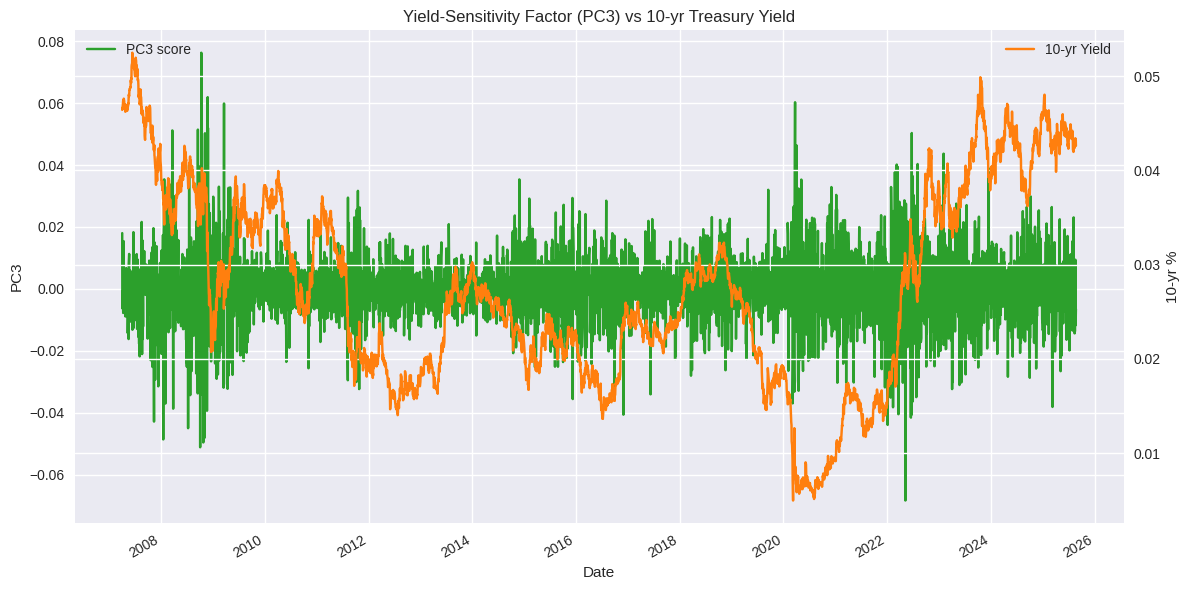

In [16]:
fig, ax1 = plt.subplots(figsize=(12,6))
PC3_score.plot(ax=ax1, color="tab:green", label="PC3 score")
ax1.set_ylabel("PC3")
ax2 = ax1.twinx()
tnx.plot(ax=ax2, color="tab:orange", label="10-yr Yield")
ax2.set_ylabel("10-yr %")
ax1.set_title("Yield-Sensitivity Factor (PC3) vs 10-yr Treasury Yield")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout()


In [17]:
evr

,EVR1,EVR2,EVR3,EVR4,EVR5,EVR6,EVR7,EVR8,EVR9
Date,,,,,,,,,
2007-04-02,0.738875,0.077023,0.054117,0.032330,0.026784,0.022349,0.019606,0.017987,0.010928
2007-04-03,0.739954,0.077982,0.052211,0.032397,0.027068,0.022314,0.019698,0.017729,0.010646
2007-04-04,0.737338,0.077661,0.051974,0.032428,0.028363,0.022375,0.020841,0.018489,0.010531
2007-04-05,0.737515,0.076621,0.051976,0.032498,0.028447,0.023848,0.020837,0.018243,0.010015
2007-04-09,0.738552,0.071957,0.052704,0.032809,0.028459,0.025451,0.021754,0.018443,0.009872
...,...,...,...,...,...,...,...,...,...
2025-08-18,0.472952,0.137128,0.123500,0.077659,0.065427,0.038543,0.036443,0.030392,0.017955
2025-08-19,0.467197,0.144190,0.124468,0.078090,0.062985,0.038355,0.036645,0.030382,0.017689
2025-08-20,0.466849,0.140330,0.125821,0.077256,0.063150,0.039667,0.038226,0.030626,0.018076


In [18]:
# linear regression EVR vs credit spreads
Y = spread_market.loc["2007-03-30":]  # dependent variable (annual intensity)
X = evr[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols = sm.OLS(Y, X).fit()
print(ols.summary())

ValueError: The indices for endog and exog are not aligned

In [ ]:
# plot regression
evr_spread_df = pd.concat([evr, spread_market], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from markets', data=evr_spread_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)

In [ ]:
Y

In [ ]:
# linear regression pc scores vs credit spreads
Y = spread_market.loc["2007-03-30":]  # dependent variable (annual intensity)
X = pcscores[["PC1_score", "PC2_score", "PC3_score"]]
X = sm.add_constant(X)   # intercept

ols = sm.OLS(Y, X).fit()
print(ols.summary())

In [ ]:
# plot regression (pc scores)
pcscores_spread_df = pd.concat([pcscores, spread_market], axis=1)
sns.regplot(x='PC1_score', y='Credit Spread from markets', data=pcscores_spread_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=95)

In [ ]:
pcscores

In [ ]:
spread_fred.loc["2007-03-30":]

In [ ]:
evr

In [ ]:
# linear regression EVR vs credit spreads
Y = spread_fred.loc["2007-03-30":].ffill()  # dependent variable (annual intensity)
X = evr[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_fred = sm.OLS(Y, X).fit()
print(ols_fred.summary())

In [ ]:
# plot regression
evr_spread_fred_df = pd.concat([evr, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_fred_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)

In [ ]:
# eigendecomposition on rolling Spearman correlation matrix, then pick explained variance
evr_spearman, pcscores_spearman, _ = rolling_pca(sector_rets, "spearman", window=60)

EVR1 = evr_spearman["EVR1"]
PC2_z = (pcscores_spearman["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score = pcscores_spearman["PC3_score"]

# vix = prices["^VIX"].loc[EVR1.index]
# tnx = prices["^TNX"].loc[EVR1.index] / 100        # ^TNX quote is yield×100

In [ ]:
evr_spearman

In [ ]:
# linear regression EVR (from Spearman corr) vs credit spreads
Y = spread_fred.loc["2007-03-30":].ffill()  # dependent variable (annual intensity)
X = evr_spearman[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_spearman = sm.OLS(Y, X).fit()
print(ols_spearman.summary())

In [ ]:
# plot regression
evr_spread_spearman_df = pd.concat([evr_spearman, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_spearman_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)

##### References

- FRED database, **https://fred.stlouisfed.org/series**, accessed on 25 August 2025